In [1]:
import pandas as pd
import os
import re
import numpy as np
import nibabel
import argparse
import textwrap
import time
from multiprocessing import Pool
from numpy import count_nonzero
import statsmodels
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats

%matplotlib inline

In [124]:
allData = pd.read_csv('/Users/yoobinkwak/Desktop/BL_thalamus.csv', index_col=0)
#allData = pd.read_csv('/Users/yoobinkwak/Desktop/BL_striatum.csv', index_col=0)

In [109]:
allData

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity,Group
0,DNO22,left,caudalMotor,5,1.700106e+06,38963,16778,323,421971.0,0.800621,273537.802196,404,437742.0,DNO,4212247.0,0.103921,OCD
1,DNO22,left,cognitive,5,1.700106e+06,85553,16778,764,285195.0,0.862539,183358.058752,1031,305919.0,DNO,4212247.0,0.072626,OCD
2,DNO22,left,limbic,5,1.700106e+06,35524,16778,804,1276138.0,0.872358,822332.766824,964,1312402.0,DNO,4212247.0,0.311568,OCD
3,DNO22,left,rostralMotor,5,1.700106e+06,76878,16778,431,545212.0,0.817182,355660.929384,584,571359.0,DNO,4212247.0,0.135642,OCD
4,DNO22,left,parietal,5,1.700106e+06,231334,16778,449,672663.0,0.829731,441199.235517,664,737710.0,DNO,4212247.0,0.175135,OCD
5,DNO22,left,temporal,5,1.700106e+06,193097,16778,797,707024.0,0.860448,462206.765277,1047,746492.0,DNO,4212247.0,0.177219,OCD
6,DNO22,left,occipital,5,1.700106e+06,127489,16778,562,89484.0,0.852212,59478.477821,853,100623.0,DNO,4212247.0,0.023888,OCD
7,DNO22,left,caudalMotor,10,1.700106e+06,38963,16778,273,411518.0,0.803555,266835.969883,347,437742.0,DNO,4212247.0,0.103921,OCD
8,DNO22,left,cognitive,10,1.700106e+06,85553,16778,527,260708.0,0.858933,167624.173615,774,305919.0,DNO,4212247.0,0.072626,OCD
9,DNO22,left,limbic,10,1.700106e+06,35524,16778,652,1224513.0,0.872507,788136.517018,805,1312402.0,DNO,4212247.0,0.311568,OCD


In [110]:
allData.shape

(3640, 17)

In [111]:
allData['threshold'].dtypes

dtype('O')

In [112]:
allData['threshold'] = allData.threshold.astype('str')

In [113]:
allData['threshold'] = allData['threshold'].str[-2:]

In [114]:
allData['group'] = allData['subject'].str[:3]

In [119]:
total_connectivity_sum = allData.groupby(['threshold',
                                          'subject', 
                                          'side']).sum().reset_index()[['subject',
                                                                        'side',
                                                                        'threshold',
                                                                        'total_connectivity_raw']]

total_connectivity_sum.columns = ['subject', 'side', 'threshold', 'total_connectivity_raw_sum']

In [120]:
total_connectivity_sum

,subject,side,threshold,total_connectivity_raw_sum
0,DNO08,left,10,4262351.0
1,DNO08,right,10,3710024.0
2,DNO10,left,10,6163716.0
3,DNO10,right,10,4210322.0
4,DNO11,left,10,4411160.0
5,DNO11,right,10,3733627.0
6,DNO12,left,10,6519297.0
7,DNO12,right,10,6480981.0
8,DNO13,left,10,4748091.0
9,DNO13,right,10,3934005.0


In [121]:
allData = pd.merge(allData,
                  total_connectivity_sum,
                  on=['subject','side','threshold'],
                  how='inner')

In [122]:
allData['relative_connectivity'] = allData.total_connectivity_raw / allData.total_connectivity_raw_sum


In [123]:
allData

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum_x,relative_connectivity,Group,total_connectivity_raw_sum_y,total_connectivity_raw_sum
0,DNO22,left,caudalMotor,5,1.700106e+06,38963,16778,323,421971.0,0.800621,273537.802196,404,437742.0,DNO,4212247.0,0.103921,OCD,4212247.0,4212247.0
1,DNO22,left,cognitive,5,1.700106e+06,85553,16778,764,285195.0,0.862539,183358.058752,1031,305919.0,DNO,4212247.0,0.072626,OCD,4212247.0,4212247.0
2,DNO22,left,limbic,5,1.700106e+06,35524,16778,804,1276138.0,0.872358,822332.766824,964,1312402.0,DNO,4212247.0,0.311568,OCD,4212247.0,4212247.0
3,DNO22,left,rostralMotor,5,1.700106e+06,76878,16778,431,545212.0,0.817182,355660.929384,584,571359.0,DNO,4212247.0,0.135642,OCD,4212247.0,4212247.0
4,DNO22,left,parietal,5,1.700106e+06,231334,16778,449,672663.0,0.829731,441199.235517,664,737710.0,DNO,4212247.0,0.175135,OCD,4212247.0,4212247.0
5,DNO22,left,temporal,5,1.700106e+06,193097,16778,797,707024.0,0.860448,462206.765277,1047,746492.0,DNO,4212247.0,0.177219,OCD,4212247.0,4212247.0
6,DNO22,left,occipital,5,1.700106e+06,127489,16778,562,89484.0,0.852212,59478.477821,853,100623.0,DNO,4212247.0,0.023888,OCD,4212247.0,4212247.0
7,DNO22,left,caudalMotor,10,1.700106e+06,38963,16778,273,411518.0,0.803555,266835.969883,347,437742.0,DNO,4212247.0,0.103921,OCD,4212247.0,4212247.0
8,DNO22,left,cognitive,10,1.700106e+06,85553,16778,527,260708.0,0.858933,167624.173615,774,305919.0,DNO,4212247.0,0.072626,OCD,4212247.0,4212247.0
9,DNO22,left,limbic,10,1.700106e+06,35524,16778,652,1224513.0,0.872507,788136.517018,805,1312402.0,DNO,4212247.0,0.311568,OCD,4212247.0,4212247.0


In [14]:
allData.shape

(3640, 16)

In [15]:
allData.groupby(['group','side','cortex','threshold']).count()[['subject']]

subject
group side  cortex       threshold         
DNO   left  caudalMotor  10              11
                         20              11
                         5               11
                         90              11
                         95              11
            cognitive    10              11
                         20              11
                         5               11
                         90              11
                         95              11
            limbic       10              11
                         20              11
                         5               11
                         90              11
                         95              11
            occipital    10              11
                         20              11
                         5               11
                         90              11
                         95              11
            parietal     10              11
                         20              11
                         5               11
                         90              11
                         95              11
            rostralMotor 10              11
                         20              11
                         5               11
                         90              11
                         95              11
...                                     ...
UMO   right cognitive    10              15
                         20              15
                         5               15
                         90              15
                         95              15
            limbic       10              15
                         20              15
                         5               15
                         90              15
                         95              15
            occipital    10              15
                         20              15
                         5               15
                         90              15
                         95              15
            parietal     10              15
                         20              15
                         5               15
                         90              15
                         95              15
            rostralMotor 10              15
                         20              15
                         5               15
                         90              15
                         95              15
            temporal     10              15
                         20              15
                         5               15
                         90              15
                         95              15

[210 rows x 1 columns]

In [16]:
allData['subject'] = allData.subject.str[:5]

In [17]:
allData.describe()

,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,total_connectivity_raw_sum,relative_connectivity
count,3.640000e+03,3640.000000,3640.000000,3640.000000,3.640000e+03,3554.000000,3.640000e+03,3640.000000,3.640000e+03,3.640000e+03,3570.000000
mean,1.579490e+06,99103.703297,15096.201923,327.990934,4.165561e+05,0.821341,2.710946e+05,480.330220,6.906996e+05,4.834897e+06,0.142857
std,1.587593e+05,69138.812758,1773.241183,317.227279,4.109907e+05,0.064733,2.677399e+05,405.655322,4.672268e+05,1.211623e+06,0.088891
min,1.198569e+06,20321.000000,11475.000000,0.000000,0.000000e+00,0.571709,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.007130
25%,1.484512e+06,37468.750000,13863.250000,39.000000,1.128192e+05,0.780374,7.335875e+04,97.000000,2.929942e+05,4.167626e+06,0.063838
50%,1.556647e+06,70368.500000,14977.000000,248.000000,2.276470e+05,0.819601,1.480732e+05,399.000000,6.454670e+05,4.806024e+06,0.140414
75%,1.655068e+06,157254.000000,16228.750000,549.250000,6.487805e+05,0.862626,4.200437e+05,799.000000,1.006196e+06,5.831863e+06,0.204761
max,1.958597e+06,307190.000000,20302.000000,1331.000000,2.162371e+06,1.135364,1.420339e+06,1526.000000,2.189262e+06,7.563595e+06,0.429072


In [18]:
allData[allData.isnull().any(axis=1)]

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity
700,NOR15,left,caudalMotor,5,1.576093e+06,33291,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
701,NOR15,left,cognitive,5,1.576093e+06,66192,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
702,NOR15,left,limbic,5,1.576093e+06,34965,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
703,NOR15,left,rostralMotor,5,1.576093e+06,61827,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
704,NOR15,left,parietal,5,1.576093e+06,187392,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
705,NOR15,left,temporal,5,1.576093e+06,165909,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
706,NOR15,left,occipital,5,1.576093e+06,107148,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
707,NOR15,left,caudalMotor,10,1.576093e+06,33291,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
708,NOR15,left,cognitive,10,1.576093e+06,66192,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN
709,NOR15,left,limbic,10,1.576093e+06,34965,15598,0,0.0,NaN,0.000000,0,0.0,NOR,0.0,NaN


In [19]:
#allData[allData.dti_thalamus_seg_volume==0]
allData[allData.dti_striatum_seg_volume==0]

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity
700,NOR15,left,caudalMotor,5,1.576093e+06,33291,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
701,NOR15,left,cognitive,5,1.576093e+06,66192,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
702,NOR15,left,limbic,5,1.576093e+06,34965,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
703,NOR15,left,rostralMotor,5,1.576093e+06,61827,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
704,NOR15,left,parietal,5,1.576093e+06,187392,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
705,NOR15,left,temporal,5,1.576093e+06,165909,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
706,NOR15,left,occipital,5,1.576093e+06,107148,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
707,NOR15,left,caudalMotor,10,1.576093e+06,33291,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
708,NOR15,left,cognitive,10,1.576093e+06,66192,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN
709,NOR15,left,limbic,10,1.576093e+06,34965,15598,0,0.0,NaN,0.0,0,0.0,NOR,0.0,NaN


In [20]:
#sns.boxplot('side','thalamus_volume', 
            #hue='group', 
            #palette=sns.color_palette("Set2", 2), 
            #data=allData[['side','thalamus_volume','group']].drop_duplicates())
#plt.title('Volume of the thalamus', fontsize=20)
#plt.ylabel('Volume in mm3')
#plt.xlabel('Side')
#plt.show()

In [21]:
allData.loc[allData.group == 'DNO', 'Group'] = 'OCD' 
allData.loc[allData.group == 'UMO', 'Group'] = 'OCD' 
allData.loc[allData.group == 'NOR', 'Group'] = 'HC' 

In [22]:
allData['Group']

0       OCD
1       OCD
2       OCD
3       OCD
4       OCD
5       OCD
6       OCD
7       OCD
8       OCD
9       OCD
10      OCD
11      OCD
12      OCD
13      OCD
14      OCD
15      OCD
16      OCD
17      OCD
18      OCD
19      OCD
20      OCD
21      OCD
22      OCD
23      OCD
24      OCD
25      OCD
26      OCD
27      OCD
28      OCD
29      OCD
       ... 
3610     HC
3611     HC
3612     HC
3613     HC
3614     HC
3615     HC
3616     HC
3617     HC
3618     HC
3619     HC
3620     HC
3621     HC
3622     HC
3623     HC
3624     HC
3625     HC
3626     HC
3627     HC
3628     HC
3629     HC
3630     HC
3631     HC
3632     HC
3633     HC
3634     HC
3635     HC
3636     HC
3637     HC
3638     HC
3639     HC
Name: Group, Length: 3640, dtype: object

In [23]:
allData

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity,Group
0,DNO22,left,caudalMotor,5,1.700106e+06,38963,16778,323,421971.0,0.800621,273537.802196,404,437742.0,DNO,4212247.0,0.103921,OCD
1,DNO22,left,cognitive,5,1.700106e+06,85553,16778,764,285195.0,0.862539,183358.058752,1031,305919.0,DNO,4212247.0,0.072626,OCD
2,DNO22,left,limbic,5,1.700106e+06,35524,16778,804,1276138.0,0.872358,822332.766824,964,1312402.0,DNO,4212247.0,0.311568,OCD
3,DNO22,left,rostralMotor,5,1.700106e+06,76878,16778,431,545212.0,0.817182,355660.929384,584,571359.0,DNO,4212247.0,0.135642,OCD
4,DNO22,left,parietal,5,1.700106e+06,231334,16778,449,672663.0,0.829731,441199.235517,664,737710.0,DNO,4212247.0,0.175135,OCD
5,DNO22,left,temporal,5,1.700106e+06,193097,16778,797,707024.0,0.860448,462206.765277,1047,746492.0,DNO,4212247.0,0.177219,OCD
6,DNO22,left,occipital,5,1.700106e+06,127489,16778,562,89484.0,0.852212,59478.477821,853,100623.0,DNO,4212247.0,0.023888,OCD
7,DNO22,left,caudalMotor,10,1.700106e+06,38963,16778,273,411518.0,0.803555,266835.969883,347,437742.0,DNO,4212247.0,0.103921,OCD
8,DNO22,left,cognitive,10,1.700106e+06,85553,16778,527,260708.0,0.858933,167624.173615,774,305919.0,DNO,4212247.0,0.072626,OCD
9,DNO22,left,limbic,10,1.700106e+06,35524,16778,652,1224513.0,0.872507,788136.517018,805,1312402.0,DNO,4212247.0,0.311568,OCD


In [23]:
allData.shape

(3640, 17)

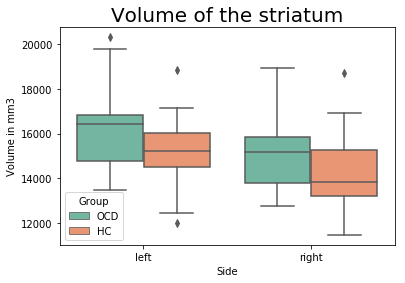

In [48]:
#sns.boxplot('side','thalamus_volume', 
sns.boxplot('side','striatum_volume', 
            hue='Group', 
            palette=sns.color_palette("Set2", 2), 
            #data=allData[['side','thalamus_volume','new_group']].drop_duplicates())
            data=allData[['side','striatum_volume','Group']].drop_duplicates())
#plt.title('Volume of the thalamus', fontsize=20)
plt.title('Volume of the striatum', fontsize=20)
plt.ylabel('Volume in mm3')
plt.xlabel('Side')
plt.show()

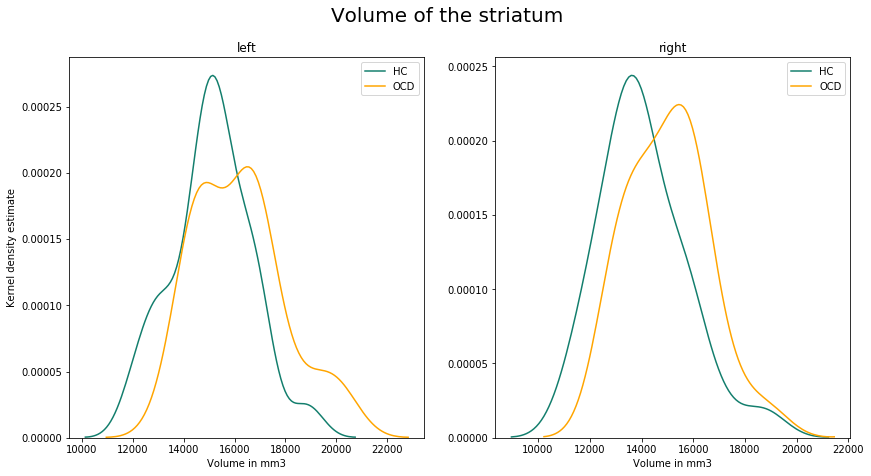

In [49]:
#gb = allData[['side','thalamus_volume','new_group']].drop_duplicates().groupby(['new_group','side'])
#var = 'thalamus_volume'
gb = allData[['side','striatum_volume','Group']].drop_duplicates().groupby(['Group','side'])
var = 'striatum_volume'

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for num, side in enumerate(['left','right']):
    sns.kdeplot(gb.get_group(('HC',side))[var], label='HC', ax=axes[num], color=sns.xkcd_rgb['blue green'])
    sns.kdeplot(gb.get_group(('OCD',side))[var], label='OCD', ax=axes[num], color='orange')
    axes[num].set_title(side)
    axes[num].set_xlabel('Volume in mm3')

#fig.suptitle('Volume of the thalamus', fontsize=20)
fig.suptitle('Volume of the striatum', fontsize=20)
axes[0].set_ylabel('Kernel density estimate')

plt.show()

In [24]:
#f = pd.ExcelFile("/Users/yoobinkwak/Downloads/baseline.xlsx")
#demo = f.parse(0)
demo = pd.read_csv("/Users/yoobinkwak/Downloads/BL_dti_2.csv")

In [148]:
#demo.columns = ['subject', 'age', 'sex']

In [25]:
demo.shape

(54, 4)

In [26]:
demo.loc[demo.subject == 'DNO20_JBJ', 'subject'] = 'UMO60_JBJ'

In [27]:
demo.loc[demo.subject == 'UMO18_CSJ', 'subject'] = 'DNO36_CSJ'

In [28]:
demo

,subject,age,sex,group
0,NOR01_LSJ,26,M,HC
1,NOR02_JIY,24,F,HC
2,NOR03_LYE,22,F,HC
3,NOR04_JJW,29,F,HC
4,NOR05_PSM,28,F,HC
5,NOR06_HYH,27,M,HC
6,NOR07_PSJ,20,M,HC
7,NOR08_LYY,25,F,HC
8,NOR09_JJK,25,M,HC
9,NOR10_KMW,22,M,HC


In [29]:
demo['subject'] = demo.subject.str[:5]

In [30]:
demo

,subject,age,sex,group
0,NOR01,26,M,HC
1,NOR02,24,F,HC
2,NOR03,22,F,HC
3,NOR04,29,F,HC
4,NOR05,28,F,HC
5,NOR06,27,M,HC
6,NOR07,20,M,HC
7,NOR08,25,F,HC
8,NOR09,25,M,HC
9,NOR10,22,M,HC


In [31]:
#allData_demo = pd.merge(allData, demo, on=['subject'], how='outer')

allData_demo = pd.merge(allData,
                      demo[['subject','age','sex']],
                      left_on='subject',
                      right_on='subject',
                      how='inner')

In [32]:
allData_demo.shape

(3640, 19)

In [33]:
allData_demo

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity,Group,age,sex
0,DNO22,left,caudalMotor,5,1.700106e+06,38963,16778,323,421971.0,0.800621,273537.802196,404,437742.0,DNO,4212247.0,0.103921,OCD,16,M
1,DNO22,left,cognitive,5,1.700106e+06,85553,16778,764,285195.0,0.862539,183358.058752,1031,305919.0,DNO,4212247.0,0.072626,OCD,16,M
2,DNO22,left,limbic,5,1.700106e+06,35524,16778,804,1276138.0,0.872358,822332.766824,964,1312402.0,DNO,4212247.0,0.311568,OCD,16,M
3,DNO22,left,rostralMotor,5,1.700106e+06,76878,16778,431,545212.0,0.817182,355660.929384,584,571359.0,DNO,4212247.0,0.135642,OCD,16,M
4,DNO22,left,parietal,5,1.700106e+06,231334,16778,449,672663.0,0.829731,441199.235517,664,737710.0,DNO,4212247.0,0.175135,OCD,16,M
5,DNO22,left,temporal,5,1.700106e+06,193097,16778,797,707024.0,0.860448,462206.765277,1047,746492.0,DNO,4212247.0,0.177219,OCD,16,M
6,DNO22,left,occipital,5,1.700106e+06,127489,16778,562,89484.0,0.852212,59478.477821,853,100623.0,DNO,4212247.0,0.023888,OCD,16,M
7,DNO22,left,caudalMotor,10,1.700106e+06,38963,16778,273,411518.0,0.803555,266835.969883,347,437742.0,DNO,4212247.0,0.103921,OCD,16,M
8,DNO22,left,cognitive,10,1.700106e+06,85553,16778,527,260708.0,0.858933,167624.173615,774,305919.0,DNO,4212247.0,0.072626,OCD,16,M
9,DNO22,left,limbic,10,1.700106e+06,35524,16778,652,1224513.0,0.872507,788136.517018,805,1312402.0,DNO,4212247.0,0.311568,OCD,16,M


In [34]:
allData.describe()

,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,total_connectivity_raw_sum,relative_connectivity
count,3.640000e+03,3640.000000,3640.000000,3640.000000,3.640000e+03,3554.000000,3.640000e+03,3640.000000,3.640000e+03,3.640000e+03,3570.000000
mean,1.579490e+06,99103.703297,15096.201923,327.990934,4.165561e+05,0.821341,2.710946e+05,480.330220,6.906996e+05,4.834897e+06,0.142857
std,1.587593e+05,69138.812758,1773.241183,317.227279,4.109907e+05,0.064733,2.677399e+05,405.655322,4.672268e+05,1.211623e+06,0.088891
min,1.198569e+06,20321.000000,11475.000000,0.000000,0.000000e+00,0.571709,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.007130
25%,1.484512e+06,37468.750000,13863.250000,39.000000,1.128192e+05,0.780374,7.335875e+04,97.000000,2.929942e+05,4.167626e+06,0.063838
50%,1.556647e+06,70368.500000,14977.000000,248.000000,2.276470e+05,0.819601,1.480732e+05,399.000000,6.454670e+05,4.806024e+06,0.140414
75%,1.655068e+06,157254.000000,16228.750000,549.250000,6.487805e+05,0.862626,4.200437e+05,799.000000,1.006196e+06,5.831863e+06,0.204761
max,1.958597e+06,307190.000000,20302.000000,1331.000000,2.162371e+06,1.135364,1.420339e+06,1526.000000,2.189262e+06,7.563595e+06,0.429072


            df        sum_sq       mean_sq          F        PR(>F)
GROUP      1.0  1.535388e+07  1.535388e+07  15.652166  2.555906e-04
SEX        1.0  1.632129e+07  1.632129e+07  16.638379  1.735881e-04
INTRAVOL   1.0  7.711378e+07  7.711378e+07  78.611925  1.340521e-11
AGE        1.0  8.651446e+04  8.651446e+04   0.088195  7.677928e-01
Residual  47.0  4.610430e+07  9.809426e+05        NaN           NaN
            df        sum_sq       mean_sq          F        PR(>F)
GROUP      1.0  1.186110e+07  1.186110e+07  11.053290  1.722619e-03
SEX        1.0  1.043345e+07  1.043345e+07   9.722873  3.103892e-03
INTRAVOL   1.0  6.716693e+07  6.716693e+07  62.592469  3.453312e-10
AGE        1.0  2.646213e+05  2.646213e+05   0.246599  6.217948e-01
Residual  47.0  5.043491e+07  1.073083e+06        NaN           NaN


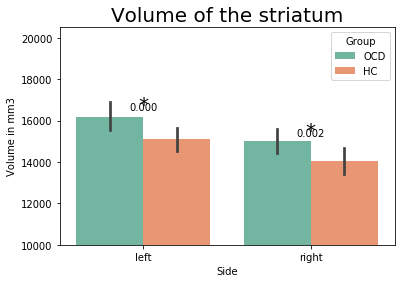

In [63]:
df = allData_demo[['subject',
              'side',
              'intra_vol',
              #'thalamus_volume',
              'striatum_volume',
              'age',
              'sex',
              'Group']].drop_duplicates()

#ax = sns.barplot('side','thalamus_volume', 
ax = sns.barplot('side','striatum_volume', 
                 hue = 'Group', 
                 palette = sns.color_palette("Set2", 2), 
                 data = df)
#ax.set_title('Volume of the thalamus', fontsize=20)
ax.set_title('Volume of the striatum', fontsize=20)
ax.set_ylabel('Volume in mm3')
#ax.set_ylim(8000, 10000)
ax.set_ylim(10000, 20500)
ax.set_xlabel('Side')

#compare = 'thalamus_volume'
compare = 'striatum_volume'

for num, side in enumerate(['left', 'right']):
    x = df.groupby('side').get_group(side)
    GROUP = x['Group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']
    INTRAVOL = x['intra_vol']
    
    formula = 'VAR ~ GROUP + INTRAVOL + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:
        print(output)
        gb = x.groupby('Group')
        
        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        ax.annotate("*", 
                    xy=(num, group_mean_upper+group_std_upper/3), 
                    va='center', ha='center', fontsize=20)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                    xy=(num, group_mean_upper+group_std_upper/4), 
                    va='center', ha='center', fontsize=10)

        plt.savefig("/Users/yoobinkwak/Desktop/OCD_20190312/seed_vol_BL.png")
plt.show()


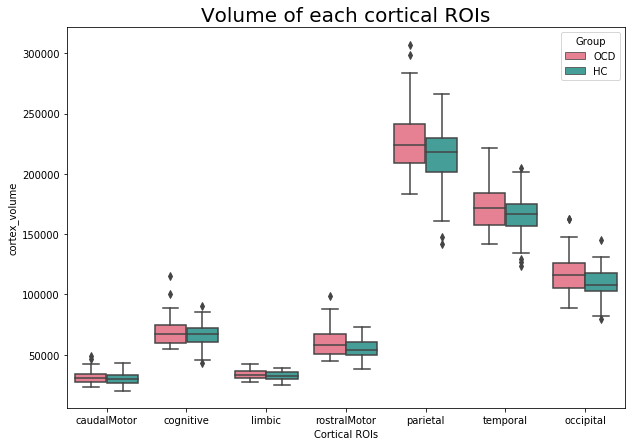

In [68]:
ax = plt.figure(figsize=(10,7))
ax = sns.boxplot('cortex','cortex_volume', 
                 hue='Group', 
                 palette=sns.color_palette("husl",2),
                 data=allData_demo[['subject', 'cortex','cortex_volume','Group']].drop_duplicates())
ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')
plt.show()

             df        sum_sq       mean_sq          F        PR(>F)
GROUP       1.0  4.422386e+07  4.422386e+07   4.693463  3.265338e-02
SEX         1.0  3.970188e+08  3.970188e+08  42.135469  3.312628e-09
AGE         1.0  3.830428e+05  3.830428e+05   0.040652  8.406203e-01
Residual  100.0  9.422437e+08  9.422437e+06        NaN           NaN
             df        sum_sq       mean_sq          F    PR(>F)
GROUP       1.0  5.198655e+08  5.198655e+08   6.222682  0.014251
SEX         1.0  1.603550e+09  1.603550e+09  19.194162  0.000029
AGE         1.0  1.112705e+08  1.112705e+08   1.331885  0.251221
Residual  100.0  8.354365e+09  8.354365e+07        NaN       NaN
             df        sum_sq       mean_sq          F        PR(>F)
GROUP       1.0  3.787397e+09  3.787397e+09   6.350905  1.331450e-02
SEX         1.0  1.727860e+10  1.727860e+10  28.973654  4.857497e-07
AGE         1.0  3.622380e+09  3.622380e+09   6.074196  1.542209e-02
Residual  100.0  5.963555e+10  5.963555e+08        NaN

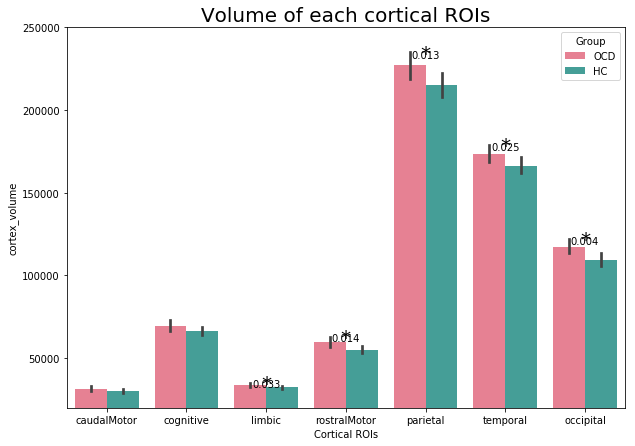

In [75]:

ax = plt.figure(figsize=(10,7))
ax = sns.barplot('cortex','cortex_volume', 
                 hue='Group', 
                 palette=sns.color_palette("husl",2),
                 data=allData_demo[['subject',  
                               'cortex', 
                               'cortex_volume',
                               'Group']].drop_duplicates())
#ax.set_ylim(10000, 70000)
ax.set_ylim(20000, 250000)

ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')


compare = 'cortex_volume'
for num, cortex in enumerate(allData_demo.cortex.unique()):
    x = allData_demo[['subject',
                    'cortex_volume', 
                    'Group', 
                    'cortex', 
                    'age', 
                    'sex']].drop_duplicates().groupby('cortex').get_group(cortex)
    GROUP = x['Group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']

    formula = 'VAR ~ GROUP + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:

        print(output)
        gb = x.groupby('Group')

        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

        conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
#         print(conf_int_a)
#         ax.annotate("*", 
#                     xy=(num, conf_int_a[1]), 
#                     va='center', ha='center', fontsize=20)
       
    plt.savefig("/Users/yoobinkwak/Desktop/OCD_20190312/target_vol_BL.png")

plt.show()

            df        sum_sq       mean_sq          F    PR(>F)
GROUP      1.0  1.067748e+09  1.067748e+09   6.665930  0.012935
SEX        1.0  2.496783e+09  2.496783e+09  15.587363  0.000257
AGE        1.0  1.591380e+07  1.591380e+07   0.099349  0.753978
Residual  48.0  7.688638e+09  1.601799e+08        NaN       NaN
            df        sum_sq       mean_sq          F    PR(>F)
GROUP      1.0  5.804787e+08  5.804787e+08   6.383588  0.014869
SEX        1.0  1.401796e+09  1.401796e+09  15.415703  0.000275
AGE        1.0  2.582763e+07  2.582763e+07   0.284029  0.596531
Residual  48.0  4.364783e+09  9.093298e+07        NaN       NaN


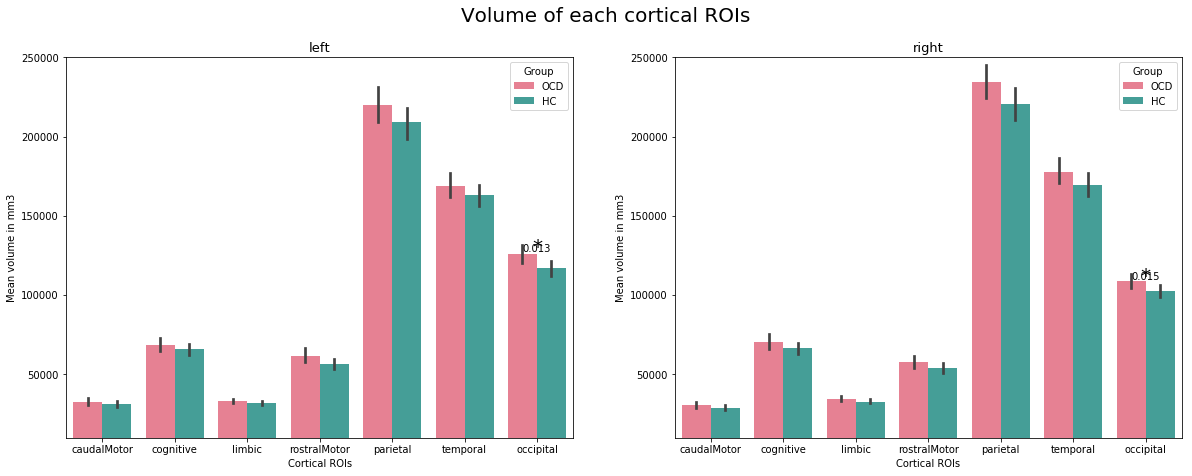

In [76]:
df_gb = allData_demo.groupby('side')
fig, axes = plt.subplots(ncols=2, figsize=(20,7))
for side_num, side in enumerate(['left','right']):
    df = df_gb.get_group(side)[['cortex',
                                'cortex_volume',
                                'subject',
                                'Group',
                                'age',
                                'sex']].drop_duplicates()
    
    sns.barplot('cortex',
                'cortex_volume',
                hue='Group', 
                palette=sns.color_palette("husl",2),
                data=df, 
                ax=axes[side_num])
    
    #axes[side_num].set_ylim(10000, 70000)
    axes[side_num].set_ylim(10000, 250000)
    axes[side_num].set_title(side, fontsize=13)
    axes[side_num].set_xlabel('Cortical ROIs')
    axes[side_num].set_ylabel('Mean volume in mm3')

    compare = 'cortex_volume'
    for num, cortex in enumerate(allData_demo.cortex.unique()):
        x = df.groupby('cortex').get_group(cortex)
        GROUP = x['Group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        
        # If there is significant group effect
        if output['PR(>F)'].GROUP < 0.05:
            print(output)
            gb = x.groupby('Group')
            groups = list(gb.groups.keys())

            # Determine the upper boundary of the plot
            # If the first group has higher mean than the second group
            if gb.get_group(groups[0])[compare].mean() > gb.get_group(groups[1])[compare].mean():
                group_mean_upper = gb.get_group(groups[0])[compare].mean()
                group_std_upper = gb.get_group(groups[0])[compare].std()
            # If the second group has higher mean than the second group
            else:
                group_mean_upper = gb.get_group(groups[1])[compare].mean()
                group_std_upper = gb.get_group(groups[1])[compare].std()
            
            # Estimate confidence interval
            # Edit here to make the significant sign higher up from the bar plot
            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('*', 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=20)
            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=10)

        plt.savefig("/Users/yoobinkwak/Desktop/OCD_20190312/hemi_target_vol_BL.png")

fig.suptitle('Volume of each cortical ROIs', fontsize=20)
plt.show()

In [77]:
allData_demo.head()

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity,Group,age,sex
0,DNO22,left,caudalMotor,5,1.700106e+06,38963,16778,323,421971.0,0.800621,273537.802196,404,437742.0,DNO,4212247.0,0.103921,OCD,16,M
1,DNO22,left,cognitive,5,1.700106e+06,85553,16778,764,285195.0,0.862539,183358.058752,1031,305919.0,DNO,4212247.0,0.072626,OCD,16,M
2,DNO22,left,limbic,5,1.700106e+06,35524,16778,804,1276138.0,0.872358,822332.766824,964,1312402.0,DNO,4212247.0,0.311568,OCD,16,M
3,DNO22,left,rostralMotor,5,1.700106e+06,76878,16778,431,545212.0,0.817182,355660.929384,584,571359.0,DNO,4212247.0,0.135642,OCD,16,M
4,DNO22,left,parietal,5,1.700106e+06,231334,16778,449,672663.0,0.829731,441199.235517,664,737710.0,DNO,4212247.0,0.175135,OCD,16,M


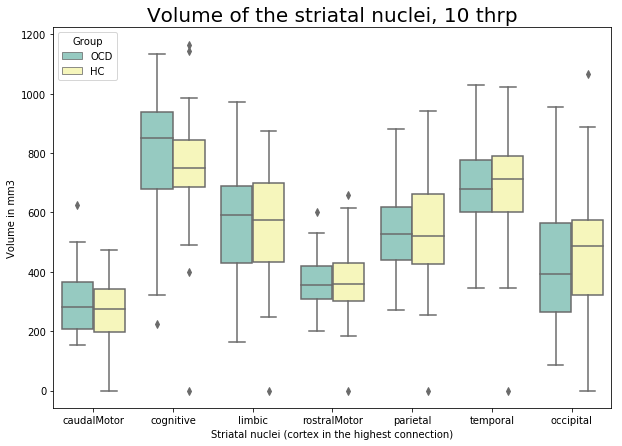

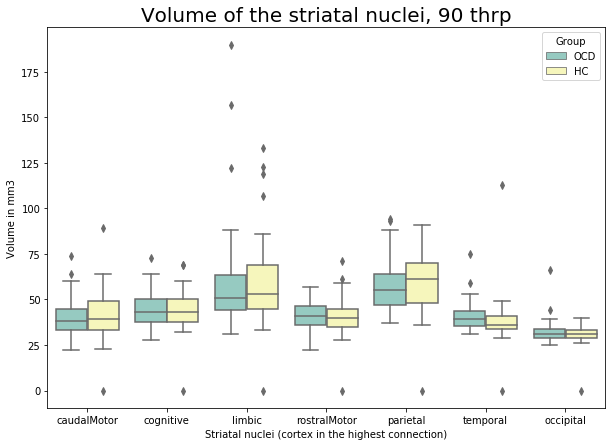

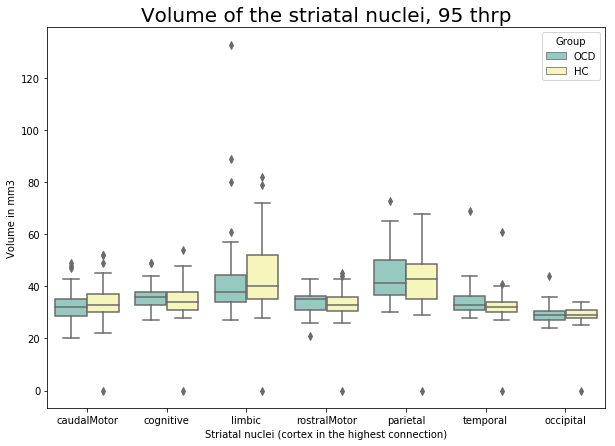

In [78]:
for thr in '10', '90', '95':
#     mk = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    #ax = sns.boxplot('cortex', 'dti_thalamus_seg_volume', 
    ax = sns.boxplot('cortex', 'dti_striatum_seg_volume',                 
                     hue='Group', palette=sns.color_palette("Set3", 2),
                data=allData_demo[['subject',
                                 'cortex',
                                 #'dti_thalamus_seg_volume',
                                 'dti_striatum_seg_volume',
                                 'Group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    #ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_title('Volume of the striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    #ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    ax.set_xlabel('Striatal nuclei (cortex in the highest connection)')
    
    plt.show()

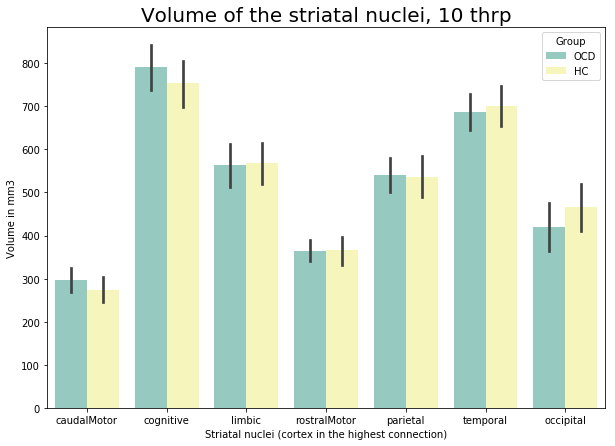

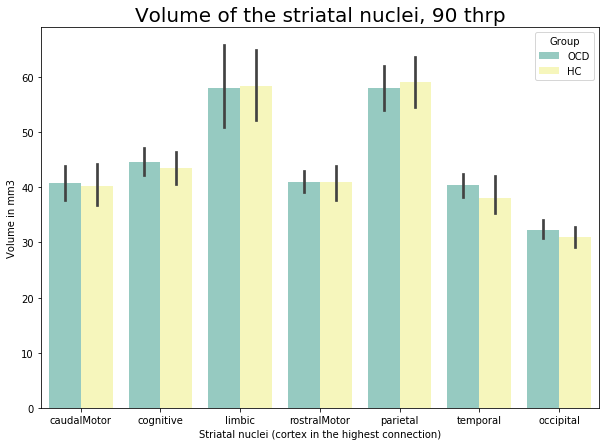

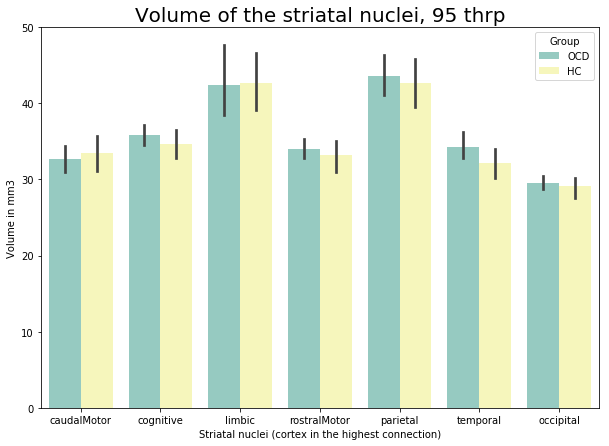

In [79]:
for thr in '10', '90', '95':
#     volume = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    #ax = sns.barplot('cortex', 'dti_thalamus_seg_volume', 
    ax = sns.barplot('cortex', 'dti_striatum_seg_volume', 
                     hue='Group', palette=sns.color_palette("Set3", 2),
                data=allData_demo[['subject',
                                 'cortex',
                                 #'dti_thalamus_seg_volume',
                                 'dti_striatum_seg_volume',
                                 'Group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    #ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_title('Volume of the striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    #ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    ax.set_xlabel('Striatal nuclei (cortex in the highest connection)')
    
    
    #compare = 'dti_thalamus_seg_volume'
    compare = 'dti_striatum_seg_volume'
    for num, cortex in enumerate(allData_demo.cortex.unique()):
        x = allData_demo[['subject',
                        'cortex',
                        #'dti_thalamus_seg_volume',
                        'dti_striatum_seg_volume',
                        'age',
                        'sex',
                        'Group',
                        'threshold']].drop_duplicates().groupby(['cortex','threshold']).get_group((cortex, thr))
        GROUP = x['Group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('Group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.show()

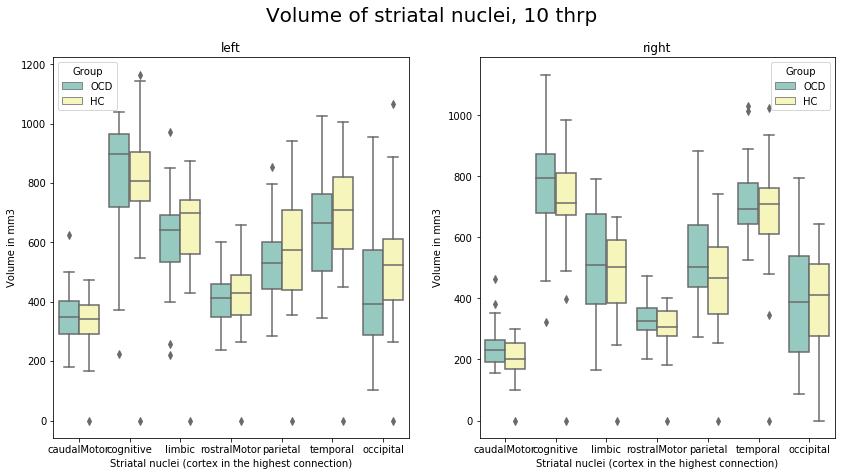

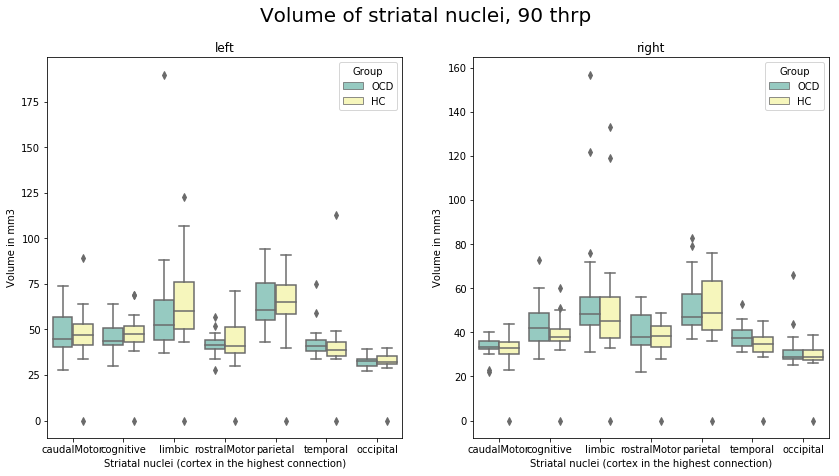

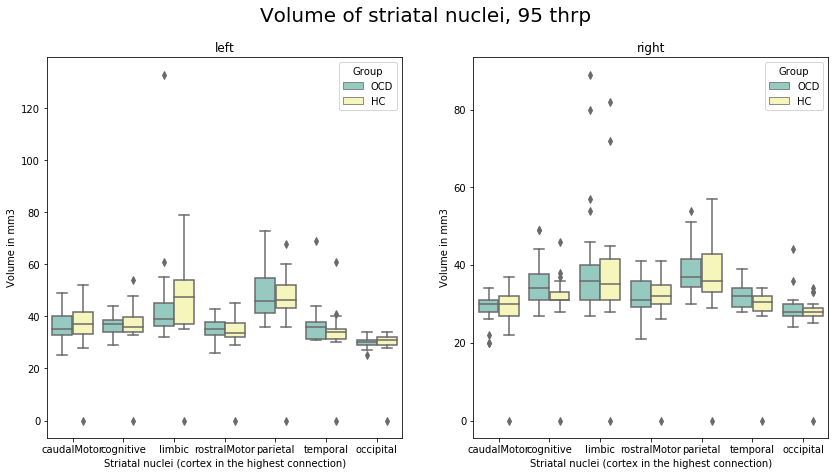

In [80]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    #'dti_thalamus_seg_volume',
                    'dti_striatum_seg_volume',
                    hue='Group', 
                    palette=sns.color_palette("Set3", 2),
                    data=allData_demo[['subject','side','cortex','threshold','Group',
                                     #'dti_thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                                     'dti_striatum_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        #axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_xlabel('Striatal nuclei (cortex in the highest connection)')
        axes[num].set_title(side)


    #fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    fig.suptitle('Volume of striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

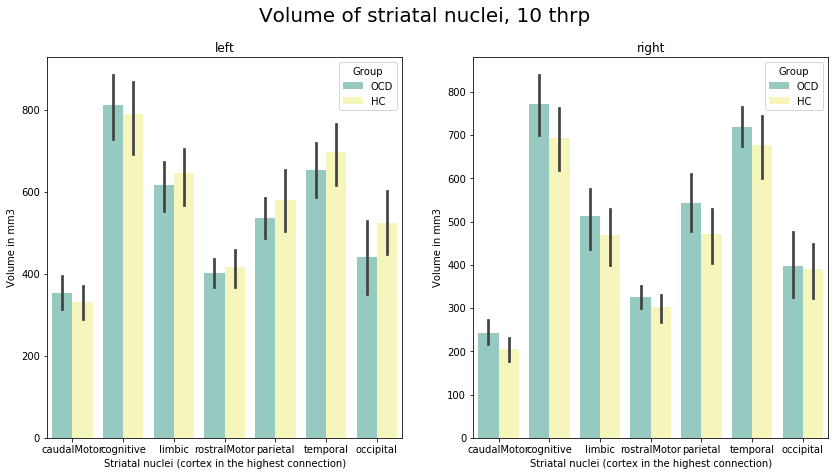

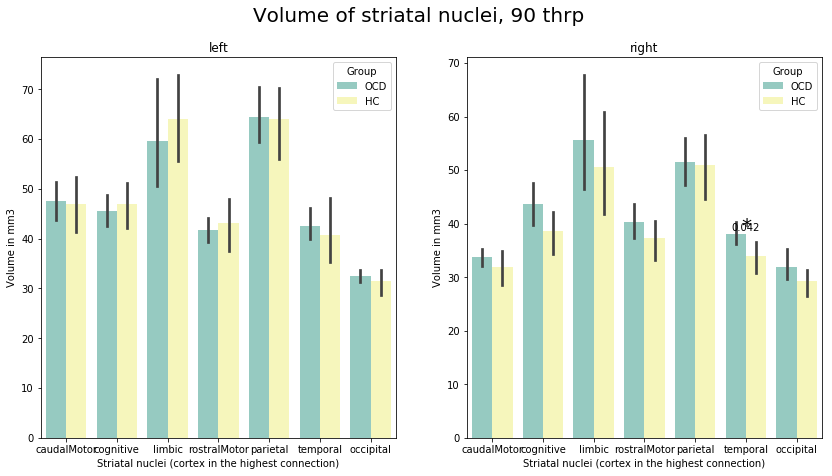

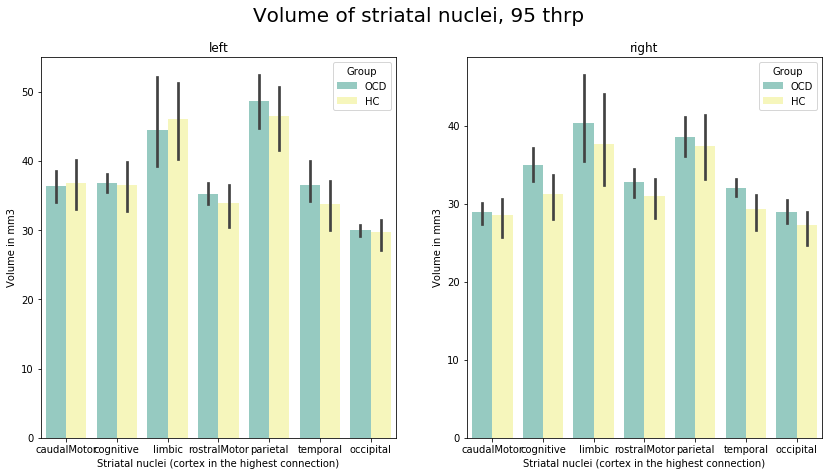

In [81]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    #'dti_thalamus_seg_volume',
                    'dti_striatum_seg_volume',
                    hue='Group', 
                    palette=sns.color_palette("Set3", 2),
                    data=allData_demo[['subject','side','cortex','threshold','Group',
                                     #'dti_thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                                     'dti_striatum_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        #axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_xlabel('Striatal nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

        #compare = 'dti_thalamus_seg_volume'
        compare = 'dti_striatum_seg_volume'
        for roi_num, cortex in enumerate(allData_demo.cortex.unique()):
            x = allData_demo[['subject','side','cortex','threshold','Group','age','sex',
                                     #'dti_thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold','cortex']).get_group((side, thr, cortex))
                                     'dti_striatum_seg_volume']].drop_duplicates().groupby(['side','threshold','cortex']).get_group((side, thr, cortex))
            GROUP = x['Group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
        #         print(output)
                gb = x.groupby('Group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)

    #fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    fig.suptitle('Volume of striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

In [82]:
allData_demo.head()

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity,Group,age,sex
0,DNO22,left,caudalMotor,5,1.700106e+06,38963,16778,323,421971.0,0.800621,273537.802196,404,437742.0,DNO,4212247.0,0.103921,OCD,16,M
1,DNO22,left,cognitive,5,1.700106e+06,85553,16778,764,285195.0,0.862539,183358.058752,1031,305919.0,DNO,4212247.0,0.072626,OCD,16,M
2,DNO22,left,limbic,5,1.700106e+06,35524,16778,804,1276138.0,0.872358,822332.766824,964,1312402.0,DNO,4212247.0,0.311568,OCD,16,M
3,DNO22,left,rostralMotor,5,1.700106e+06,76878,16778,431,545212.0,0.817182,355660.929384,584,571359.0,DNO,4212247.0,0.135642,OCD,16,M
4,DNO22,left,parietal,5,1.700106e+06,231334,16778,449,672663.0,0.829731,441199.235517,664,737710.0,DNO,4212247.0,0.175135,OCD,16,M


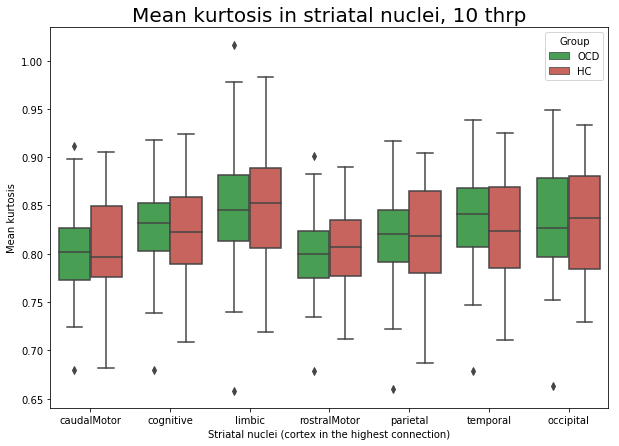

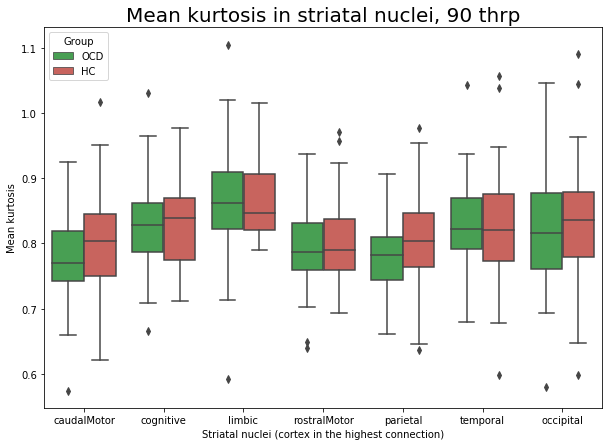

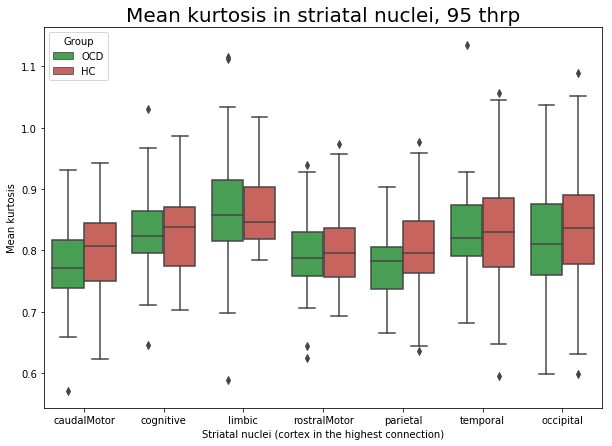

In [83]:
df_gb = allData_demo.groupby('threshold')
for thr in '10', '90', '95':
    ax = plt.figure(figsize=(10,7))
    ax = sns.boxplot('cortex',
                     #'thalamus_seg_mk',
                     'striatum_seg_mk',
                     hue='Group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data = df_gb.get_group(thr))     

    #ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_title('Mean kurtosis in striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    #ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    ax.set_xlabel('Striatal nuclei (cortex in the highest connection)')
    plt.show()

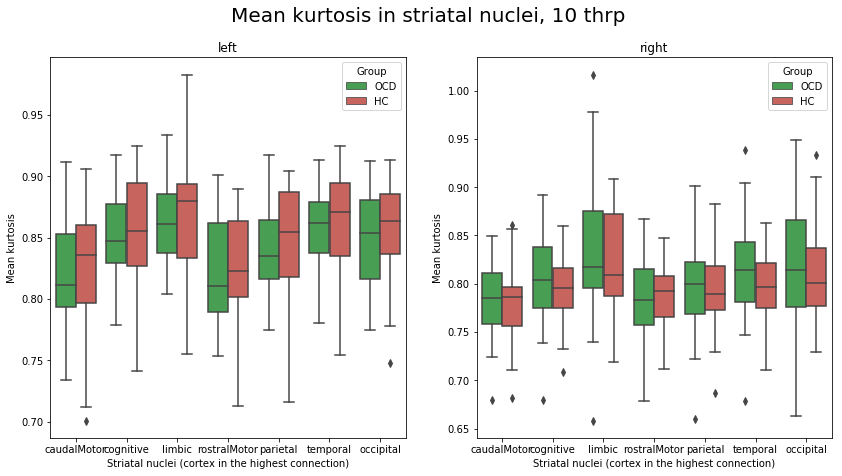

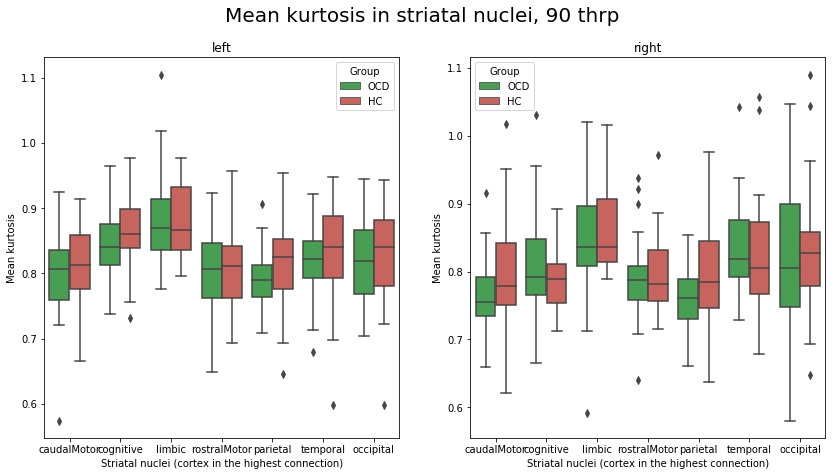

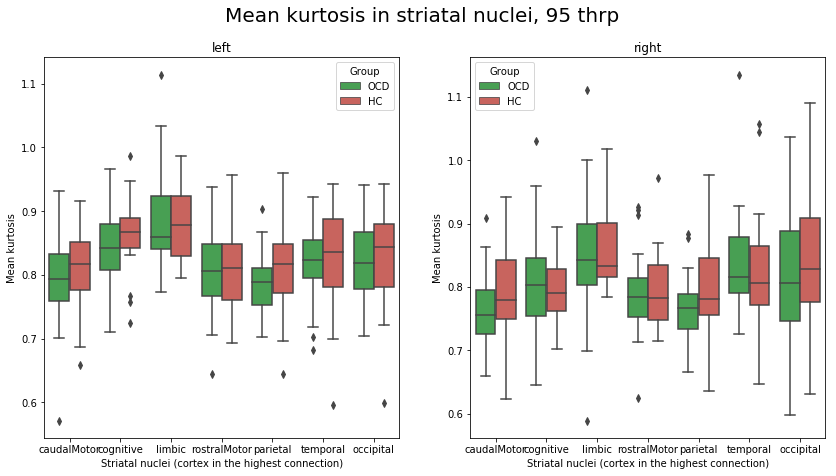

In [84]:
df_gb = allData_demo.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    #'thalamus_seg_mk',
                    'striatum_seg_mk',
                    hue='Group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        #axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_xlabel('Striatal nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

    #fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    fig.suptitle('Mean kurtosis in striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

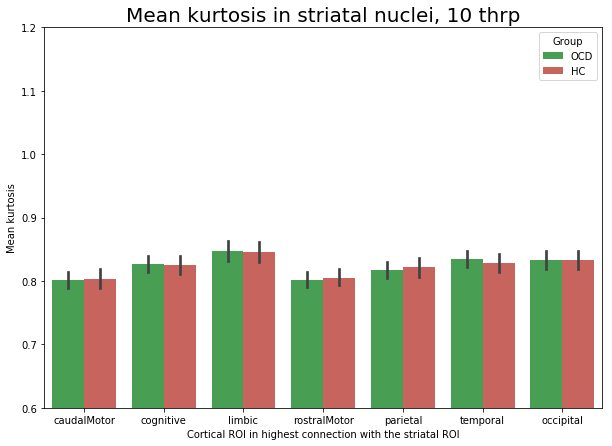

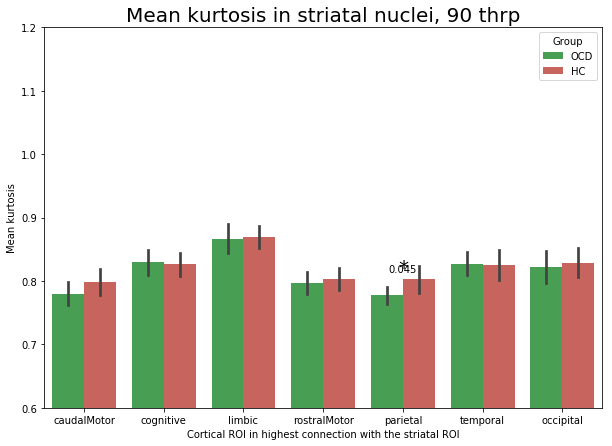

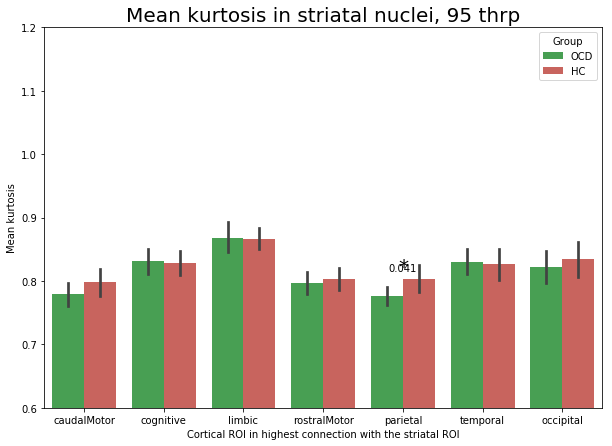

In [89]:
df_gb = allData_demo.groupby('threshold')

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.barplot('cortex', 
                     #'thalamus_seg_mk', 
                     'striatum_seg_mk', 
                     hue='Group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data=df_gb.get_group(thr))     
    ax.set_ylim(0.6, 1.2)
    #ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_title('Mean kurtosis in striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    #ax.set_xlabel('Cortical ROI in highest connection with the thalamic ROI')
    ax.set_xlabel('Cortical ROI in highest connection with the striatal ROI')
    
    #compare = 'thalamus_seg_mk'
    compare = 'striatum_seg_mk'
    for num, cortex in enumerate(allData_demo.cortex.unique()):
        x = df_gb.get_group(thr).groupby('cortex').get_group(cortex)
        GROUP = x['Group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('Group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.savefig("/Users/yoobinkwak/Desktop/OCD_20190312/MK_seeds{}_BL.png".format(thr))
 
    plt.show()



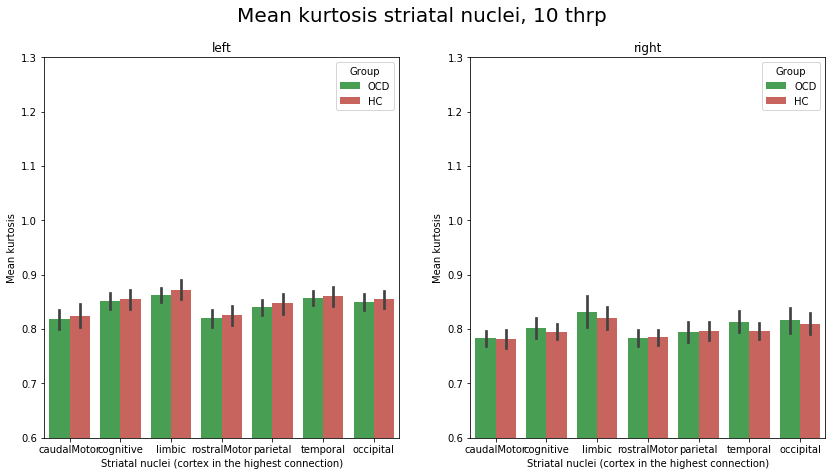

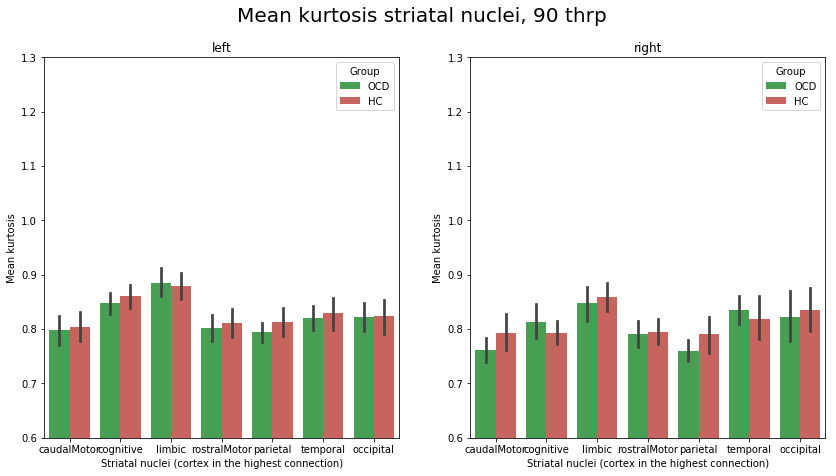

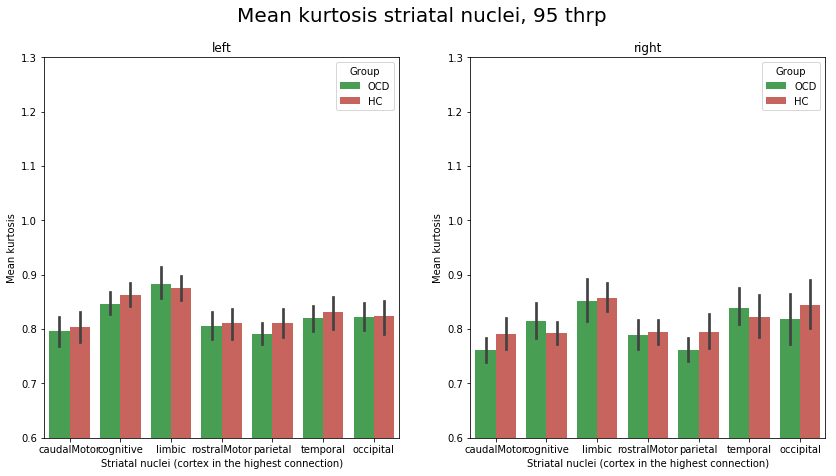

In [107]:
df_gb = allData_demo.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    #'thalamus_seg_mk',
                    'striatum_seg_mk',
                    hue='Group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        #axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_xlabel('Striatal nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        axes[num].set_ylim(0.6, 1.3)

        #compare = 'thalamus_seg_mk'
        compare = 'striatum_seg_mk'
        for roi_num, cortex in enumerate(allData_demo.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['Group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)÷
                gb = x.groupby('Group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    fig.suptitle('Mean kurtosis striatal nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

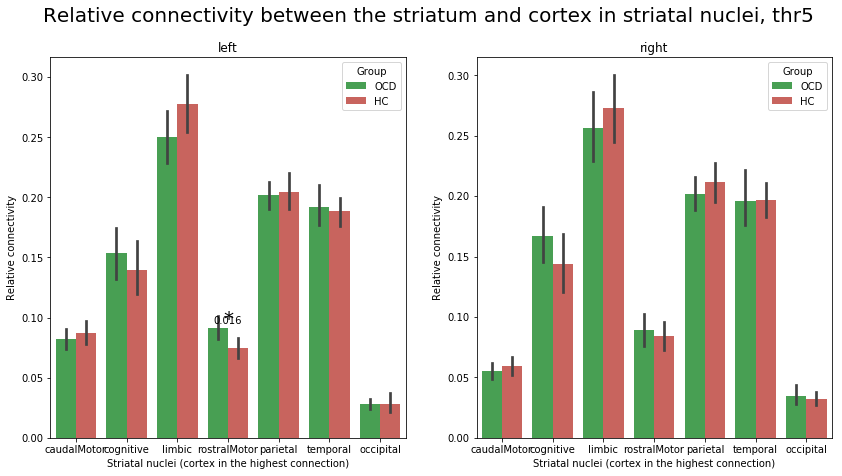

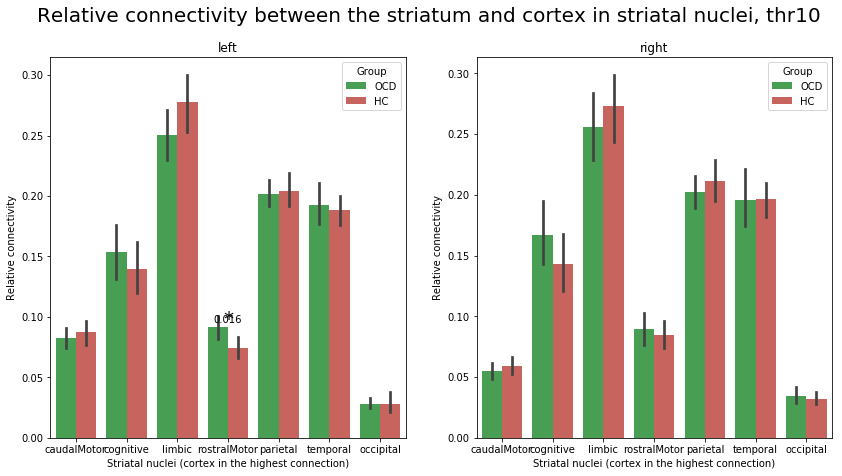

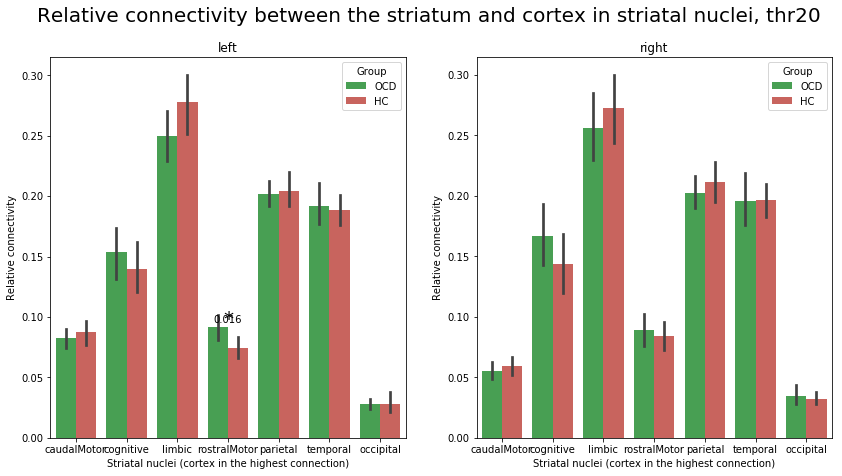

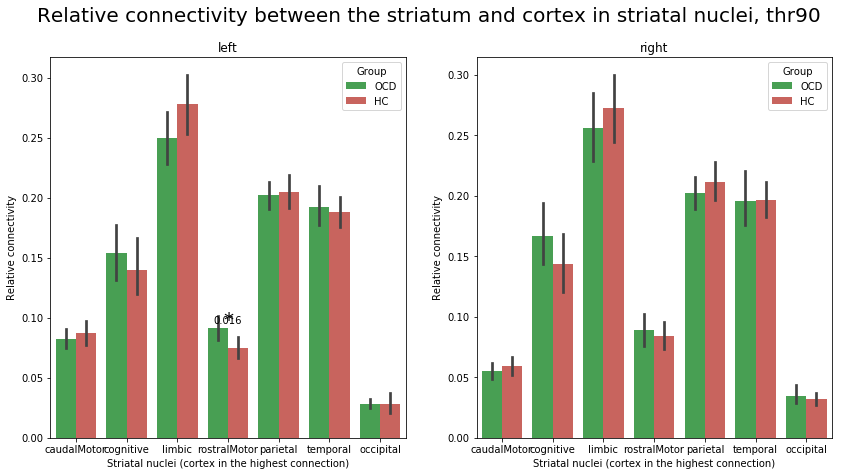

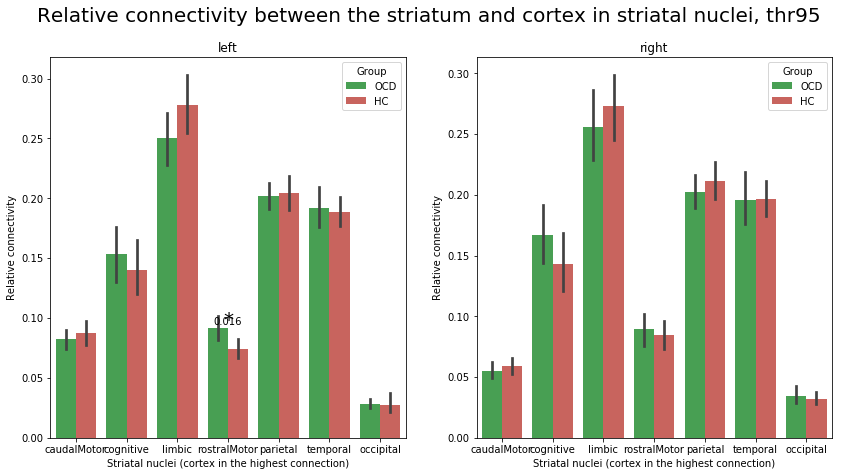

In [106]:
df_gb = allData_demo.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'relative_connectivity',
                    hue='Group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Relative connectivity')
        #axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_xlabel('Striatal nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)
    
        
        compare = 'relative_connectivity'
        for roi_num, cortex in enumerate(allData_demo.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['Group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
    #                 print(output)
                gb = x.groupby('Group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #fig.suptitle('Relative connectivity between the thalamus and cortex in thalamic nuclei'.format(thr), fontsize=20)
    fig.suptitle('Relative connectivity between the striatum and cortex in striatal nuclei, thr{}'.format(thr), fontsize=20)
    plt.show()

In [103]:
allData_demo.loc[allData_demo['subject'] == 'DNO08']

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity,Group,age,sex
2940,DNO08,left,caudalMotor,5,1.565163e+06,28590,16555,285,332729.0,0.844719,212667.271320,432,356438.0,DNO,4262351.0,0.083625,OCD,27,F
2941,DNO08,left,cognitive,5,1.565163e+06,71598,16555,1056,834753.0,0.866845,547583.836816,1274,850824.0,DNO,4262351.0,0.199614,OCD,27,F
2942,DNO08,left,limbic,5,1.565163e+06,33417,16555,531,752377.0,0.873833,473187.360883,706,793989.0,DNO,4262351.0,0.186280,OCD,27,F
2943,DNO08,left,rostralMotor,5,1.565163e+06,59165,16555,530,409141.0,0.844167,261886.144472,712,436959.0,DNO,4262351.0,0.102516,OCD,27,F
2944,DNO08,left,parietal,5,1.565163e+06,211631,16555,710,887184.0,0.864685,580076.654662,1121,975706.0,DNO,4262351.0,0.228913,OCD,27,F
2945,DNO08,left,temporal,5,1.565163e+06,160113,16555,1052,749317.0,0.873495,480719.788243,1349,771435.0,DNO,4262351.0,0.180988,OCD,27,F
2946,DNO08,left,occipital,5,1.565163e+06,103809,16555,700,71755.0,0.878779,45896.405098,1093,77000.0,DNO,4262351.0,0.018065,OCD,27,F
2947,DNO08,left,caudalMotor,10,1.565163e+06,28590,16555,207,317230.0,0.830675,201919.184502,281,356438.0,DNO,4262351.0,0.083625,OCD,27,F
2948,DNO08,left,cognitive,10,1.565163e+06,71598,16555,912,810270.0,0.865716,531776.419223,1173,850824.0,DNO,4262351.0,0.199614,OCD,27,F
2949,DNO08,left,limbic,10,1.565163e+06,33417,16555,403,709035.0,0.874440,445792.109829,590,793989.0,DNO,4262351.0,0.186280,OCD,27,F


In [104]:
allData_demo.loc[allData_demo['subject'] == 'DNO36']

,subject,side,cortex,threshold,intra_vol,cortex_volume,striatum_volume,dti_striatum_seg_volume,dti_total_connectivity,striatum_seg_mk,dki_total_connectivity,dki_striatum_seg_volume,total_connectivity_raw,group,total_connectivity_raw_sum,relative_connectivity,Group,age,sex
210,DNO36,left,caudalMotor,5,1.927794e+06,49147,20302,522,538560.0,0.879434,344942.393872,703,568533.0,DNO,6221586.0,0.091381,OCD,30,M
211,DNO36,left,cognitive,5,1.927794e+06,99964,20302,696,738189.0,0.919345,478453.613326,960,782000.0,DNO,6221586.0,0.125691,OCD,30,M
212,DNO36,left,limbic,5,1.927794e+06,38704,20302,759,1404053.0,0.906580,896445.602425,920,1448489.0,DNO,6221586.0,0.232817,OCD,30,M
213,DNO36,left,rostralMotor,5,1.927794e+06,98421,20302,559,766931.0,0.875325,494658.361092,669,807111.0,DNO,6221586.0,0.129728,OCD,30,M
214,DNO36,left,parietal,5,1.927794e+06,298819,20302,859,1235425.0,0.914709,800988.166635,1210,1293446.0,DNO,6221586.0,0.207897,OCD,30,M
215,DNO36,left,temporal,5,1.927794e+06,196001,20302,731,1099129.0,0.915263,712904.079755,1123,1163035.0,DNO,6221586.0,0.186935,OCD,30,M
216,DNO36,left,occipital,5,1.927794e+06,147999,20302,895,152514.0,0.912679,101675.848866,1280,158972.0,DNO,6221586.0,0.025552,OCD,30,M
217,DNO36,left,caudalMotor,10,1.927794e+06,49147,20302,394,515618.0,0.861942,330363.665311,502,568533.0,DNO,6221586.0,0.091381,OCD,30,M
218,DNO36,left,cognitive,10,1.927794e+06,99964,20302,493,684762.0,0.904305,444523.436850,718,782000.0,DNO,6221586.0,0.125691,OCD,30,M
219,DNO36,left,limbic,10,1.927794e+06,38704,20302,642,1364777.0,0.899737,872491.425460,785,1448489.0,DNO,6221586.0,0.232817,OCD,30,M


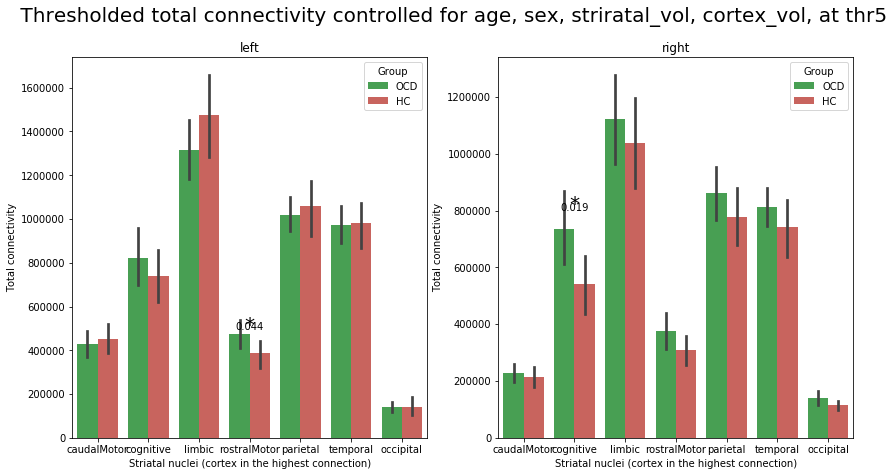

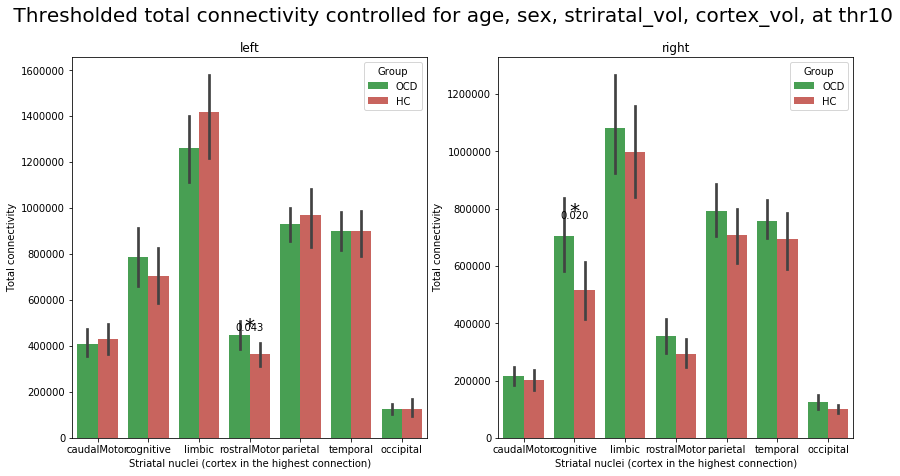

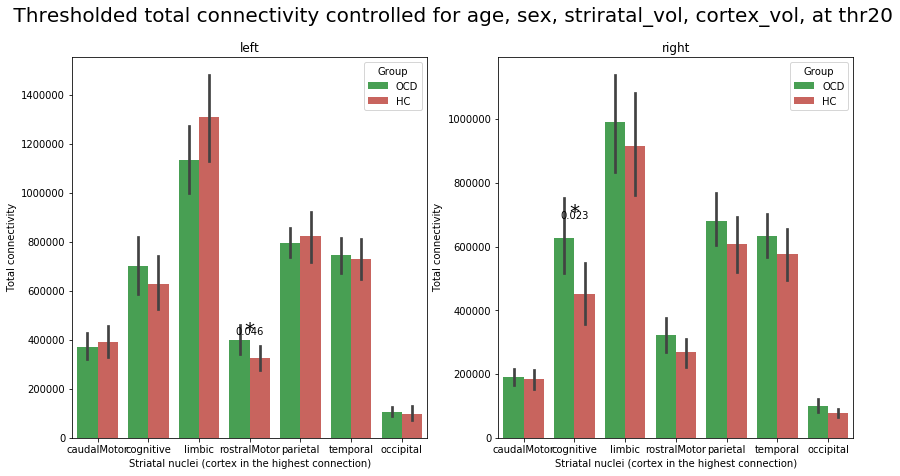

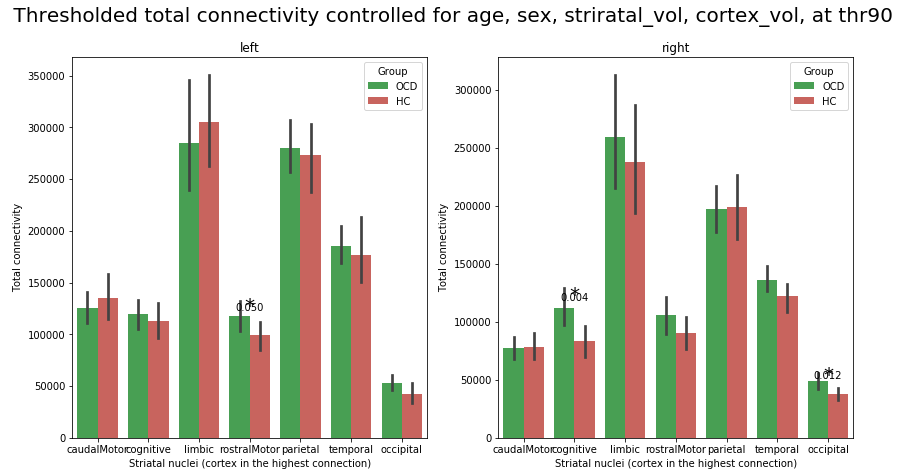

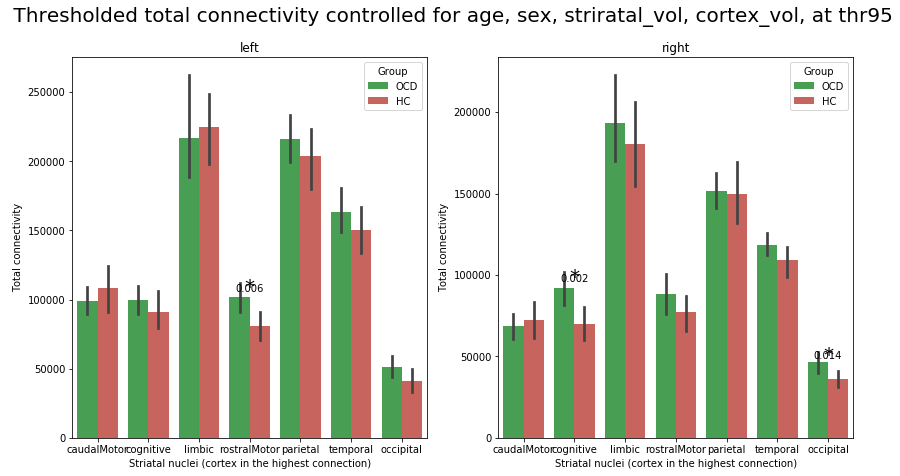

In [96]:
df_gb = allData_demo.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'dti_total_connectivity',
                    hue='Group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Total connectivity')
        #axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_xlabel('Striatal nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'dti_total_connectivity'
        for roi_num, cortex in enumerate(allData.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['Group']
            VAR = x[compare]
            #THAL_VOL = x['thalamus_volume']
            THAL_VOL = x['striatum_volume']
            CORTEX_VOL = x['cortex_volume']
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)
                gb = x.groupby('Group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #fig.suptitle(thr+' Thresholded total connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
    fig.suptitle(' Thresholded total connectivity controlled for age, sex, striratal_vol, cortex_vol, at thr{}'.format(thr), fontsize=20)
    plt.show()

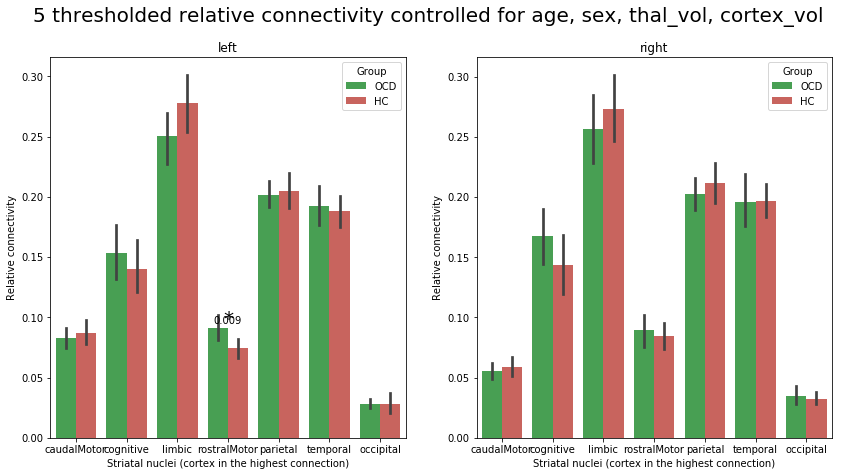

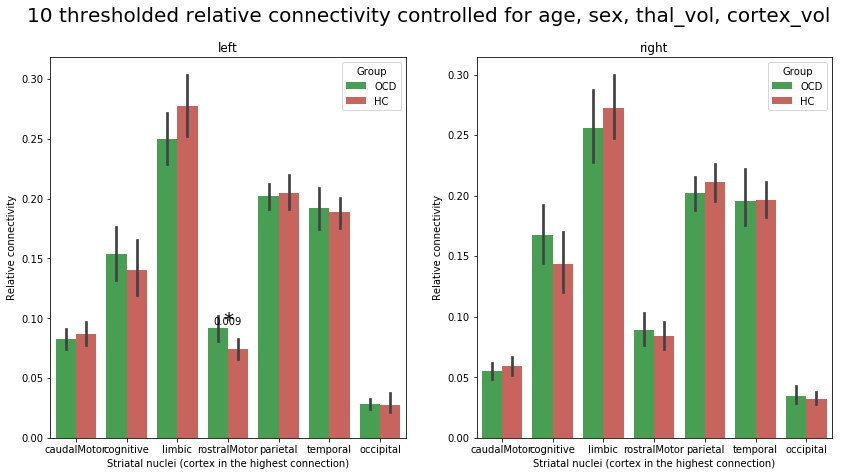

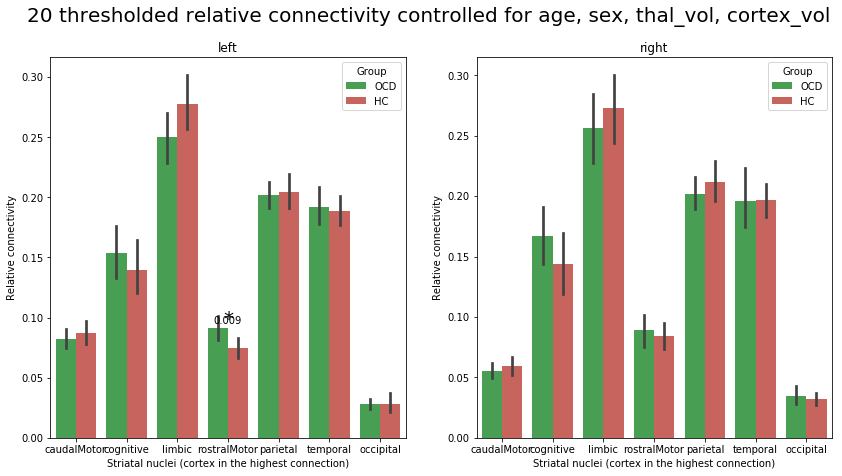

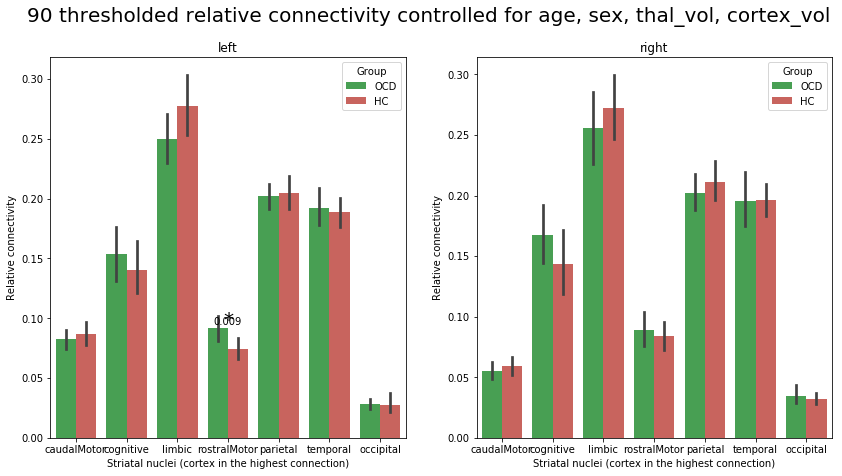

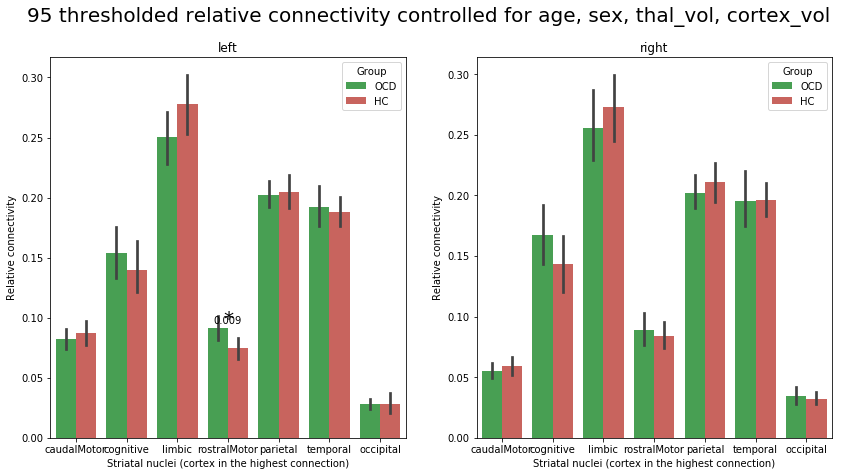

In [108]:
df_gb = allData_demo.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'relative_connectivity',
                    hue='Group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Relative connectivity')
        #axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_xlabel('Striatal nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'relative_connectivity'
        for roi_num, cortex in enumerate(allData_demo.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['Group']
            VAR = x[compare]
            #THAL_VOL = x['thalamus_volume']
            THAL_VOL = x['striatum_volume']
            CORTEX_VOL = x['cortex_volume']
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)
                gb = x.groupby('Group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle(thr+' thresholded relative connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
    plt.show()